In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
#from scipy import interp, stats
from scipy.stats import sem
import pylab as pl
from sklearn.metrics import roc_curve, auc, recall_score, matthews_corrcoef, make_scorer, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold
import math
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import json
import glob
mpl.style.use('default')
#import tqdm

CHNGE OCCLUSION SCORE TO z

Get occlusion map details for all RBPs based on Protein BERT score and classification

## Utils

In [2]:
from collections import defaultdict
from math import log

def get_IDR_coordinates(iupred_file):
    """
    IDR_file: the full file path of *.iupred.out file.
    """
    table=pd.read_table(iupred_file, skiprows=9, header=None, sep=' +', engine='python')
    table[2]=table[2].apply(float)
    disordered_coord=[rix for rix, row in table.iterrows() if row[2]>0.4] # 0-based coordinates
    return disordered_coord

def calculate_Shannon_Entropy(str_l):
    H=0
    length=len(str_l)
    aa_set=set(str_l)
    dic=defaultdict(int)
    for aa in str_l:
        dic[aa]+=1
    
    for aa in aa_set:
        p=dic[aa]*1.0/length
        H-=p*log(p,2)
    
    return H    

def get_low_complexity_coordinates(seqfile):
    with open(seqfile) as f:
        seq=f.read().split('\n')[1]
        seq_l=list(seq)
        if '*' in set(seq_l):
            seq_l.remove('*')
            
    coord=[]
    for i in range(10, len(seq_l)-10):
        H=calculate_Shannon_Entropy(seq_l[i-10:i+11])    
        if (H<3):
            coord.append(int(i))  ## 0-based coordinates.
        
    return coord

def merge_coordinates(coords):
    if len(coords)==0:
        return []
    start=coords[0]
    pre=start
    coord_list=[]
    for c in coords[1:]:
        if c==pre+1:
            pre=c
        else:
            coord_list.append('{}-{}'.format(start, pre))
            start=c
            pre=c
    
    return coord_list

def plot_annotations_v4(ax1, ax4, RBP_id, RBDs, RBDpep_table=None, RBDpep_grouped=None, IDR_file=None, seqdir='/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/hydra_2/new_proteins/zinc_finger/seq_dir', Domain_dir='/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/hydra_2/new_proteins/zinc_finger/hmmscan_out/'):
    """
    ax1: ax for domains
    ax2: ax for RBDpeps
    IDR_file: the full file path of *.iupred.out file.
    low_complexity_coords: list of integers, presenting the coordinates of amino acids within low complexity regions.
    """
    custom_colors = [
    '#FFFFFF',  # index 0 → background = white
    '#0072B2',  # index 1 → RBD domain = teal
    '#CC79A7',  # index 2 → LCR = purple
    '#009E73']  # index 3 → non-RBD domain = green
    
    cm = ListedColormap(custom_colors)

    seqfile=os.path.join(seqdir, RBP_id+'.fasta')
    Domain_file=os.path.join(Domain_dir, RBP_id+'_dom_hmmscan_out.txt.collapsed.Evalue0.1.0.01.out')
    
    if os.path.exists(seqfile):
        f=open(seqfile)
        seq=f.read().split('\n')[1]
        f.close()
        bar1=np.zeros(len(seq)) #bar for domains
        #bar2=np.zeros(len(seq)) #bar for RBDpeps
        #bar3=np.zeros(len(seq)) #bar for IDR
        bar4=np.zeros(len(seq)) #bar for low complexity
        ## add domain annotation from Pfam searches
        domain_list = [] #### Pratibha
        if os.path.exists(Domain_file):
            try:
                df=pd.read_table(Domain_file, header=None)
                domain_list=list(df[0])
                domain_coords=np.array(df[[7,8]])
                domains=zip(domain_list, domain_coords.tolist())
                for dom, (start, end) in domains:
                    start=start-1  #Convert to 0-based coordinates
                    end=end-1  #Convert to 0-based coordinates
                    if dom in RBDs:
                        bar1[start:end+1]=1 #pink
                    else:
                        bar1[start:end+1]=3 #light green
                    print('{}: {}-{}'.format(dom, start+1, end+1)) ### KEEP THIS
                    domain_coordinates.append([RBP_id, dom, start+1, end+1])
            except pd.errors.EmptyDataError:
                 domain_list=[]
                    
        low_complexity_coords=get_low_complexity_coordinates(seqfile)
        for low_complexity_coord in low_complexity_coords:
            bar4[low_complexity_coord]=2
            
        print("Low complexity coordinates: {}".format(', '.join(merge_coordinates(low_complexity_coords))))
        for coordinate in merge_coordinates(low_complexity_coords):
            low_complexity_coordinates.append([RBP_id, coordinate.split('-')[0], coordinate.split('-')[1]])

        bar1=np.array([bar1]*max(int(len(seq)/80),10))
        #bar2=np.array([bar2]*max(int(len(seq)/80),1))
        #bar3=np.array([bar3]*max(int(len(seq)/80),1))
        bar4=np.array([bar4]*max(int(len(seq)/80),10))
        #im1=ax1.imshow(bar1, cmap=cm, vmin=0, vmax=3)

        im4=ax4.imshow(bar4, cmap=cm, vmin=0, vmax=3)
        im1 = ax1.imshow(bar1, cmap=cm, vmin=0, vmax=3, aspect='auto', extent=[0, len(seq), 0, bar1.shape[0]])
        im4 = ax4.imshow(bar4, cmap=cm, vmin=0, vmax=3, aspect='auto', extent=[0, len(seq), 0, bar4.shape[0]])
        #ax1.set_title(RBP_id+'_domains',fontsize='x-large',verticalalignment='bottom')
       
        #ax4.set_title(RBP_id+'_LowComplexity',fontsize='x-large',verticalalignment='bottom')

        if len(domain_list)>0:
            for dom, (start, end) in zip(domain_list,domain_coords.tolist()):
                ax1.text((start+end)/2, 0.5*int(len(seq)/100), dom.replace('_', ' '), fontsize='large', horizontalalignment='center',verticalalignment='center')

        ax1.axes.get_yaxis().set_visible(False)

        ax4.axes.get_yaxis().set_visible(False)

In [3]:
def merge_peaks(peak_list):
    if len(peak_list)>0:
        out_list=[]
        peak0=peak_list[0]
        start0=int(peak0.split('-')[0])
        end0=int(peak0.split('-')[1])
        for peak in peak_list[1:]:
            start=int(peak.split('-')[0])
            end=int(peak.split('-')[1])
            if start<=end0:
                end0=end
            else:
                out_list.append('{}-{}'.format(start0,end0))
                start0=start
                end0=end
        
        out_list.append('{}-{}'.format(start0,end0))
        return out_list
    else:
        return []


def main4(watch_list, is_ID=False,customized_name=False, folder='Occlusions_Maps', p_threshold1=0.05, p_threshold2=0.001, savefig=False,occ_dir='/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/hydra_2/new_proteins/zinc_finger/occlusion_map/len_norm_occ',draw_ensemble_only=False):
    watch_list=[x for x in watch_list if str(x)!='nan']
    
    out_dir='./'

    #files=list(filter(lambda x: x.endswith('_Occlusion_score_matrix_full_aac_addZscoresProtLenWiseFib_pvalues.xls'), os.listdir(occ_dir)))

    xls=pd.ExcelFile('/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/hydra/Gerstberger_RBD_list_reformatted.xls')
    RBDs=set(xls.parse('Pfam domains')['Pfam RNA binding domains'])

    wind_size=20
    
    pvalue_cmap = ListedColormap(["white", "lightskyblue", "steelblue"])


    print('All the print out coordinates are 0-based (starting from 0 rather than 1).')
    for RBP in watch_list:
        
        RBP_ids=[RBP]

        for RBP_id in RBP_ids:
            print(RBP, RBP_id)
            path=os.path.join(occ_dir,RBP_id+'_Occlusion_score_matrix_full_aac_addZscoresProtLenWiseFib_pvalues_datanorm.xls')
            print(path)
            if not os.path.exists(path):
                print('Occlusion plot of '+RBP+' is not found.')
                continue


            occ_df=pd.read_table(path, index_col=0)
            
            orig_ProteinBERT=list(occ_df.original_ProteinBERT_score)[0]
            
            #delta_ProteinBERT=list(occ_df.delta_ProteinBERT)

            delta_ProteinBERT = list(occ_df.zscore_deltaProteinBERT)
            
            delta_ProteinBERT_sig_coords=np.where(np.array(occ_df.deltaProteinBERT_zscore_pvalue)<p_threshold1)[0]+int((wind_size-1)/2)
           
            delta_ProteinBERT=[0]*int((wind_size-1)/2)+delta_ProteinBERT+[0]*int((wind_size)/2)
         
            f, (ax1, ax4, ax7, ax9) = plt.subplots(4, 1, figsize=(6, 3), sharex=True,
                                                  gridspec_kw={'height_ratios': [0.5, 0.5, 2.5, 0.5]}) 
            plot_annotations_v4(ax1, ax4, RBP_id, RBDs)

         
            ax7.plot(range(len(delta_ProteinBERT)),delta_ProteinBERT, lw=0)
            ax7.set_xlim(0,len(delta_ProteinBERT))
            ax7.axhline(y=0,ls='-', color='grey', lw=1)
            #ax7.plot(delta_ProteinBERT_sig_coords, np.zeros(len(delta_ProteinBERT_sig_coords)), 'r.')
            # Fill below the curve (positive and negative separately, optional for color clarity)
            ax7.fill_between(
                range(len(delta_ProteinBERT)),
                delta_ProteinBERT,
                where=np.array(delta_ProteinBERT) >= 0,
                interpolate=True,
                color='#0072B2',
                alpha=1
            )
            
            ax7.fill_between(
                range(len(delta_ProteinBERT)),
                delta_ProteinBERT,
                where=np.array(delta_ProteinBERT) < 0,
                interpolate=True,
                color='#D55E00',
                alpha=1
            )
            plt.suptitle('{} | Standardized Delta Scores | {}'.format(RBP_id, orig_ProteinBERT),fontsize='x-large')
           
            peaks_coords1=occ_df[occ_df['deltaProteinBERT_zscore_pvalue']<=p_threshold1]['occluded_coord'] ## coordinates are 0-based.
            peaks_coords2=occ_df[occ_df['deltaProteinBERT_zscore_pvalue']<=p_threshold2]['occluded_coord'] ## coordinates are 0-based.
            print("sig peak regions (p<{}): {}".format(p_threshold1,', '.join(merge_peaks(list(peaks_coords1)))))
            print("sig peak regions (p<{}): {}".format(p_threshold2,', '.join(merge_peaks(list(peaks_coords2)))))

            for each_peak in merge_peaks(list(peaks_coords1)) + merge_peaks(list(peaks_coords2)):
                sig_peaks_list.append([RBP_id, each_peak.split('-')[0],  each_peak.split('-')[1]])
            
            #print(occ_df[occ_df['avg_zscore_deltaSVM_deltaDNN_deltaProteinBERT_pvalue']<=p_threshold2][['avg_zscore_deltaSVM_deltaDNN_deltaProteinBERT_pvalue','occluded_coord']])
            peaks_pos1=set([])
            peaks_pos2=set([])
            for coo1 in peaks_coords1:
                peaks_pos1.update(list(range(int(coo1.split('-')[0]),int(coo1.split('-')[1])+1)))
            for coo2 in peaks_coords2:
                peaks_pos2.update(list(range(int(coo2.split('-')[0]),int(coo2.split('-')[1])+1)))    
            peak_bar=np.zeros(len(occ_df)+19)
            for i in peaks_pos1:
                peak_bar[i]=1
            for j in peaks_pos2:
                peak_bar[j]=2
            peak_bar=np.array([peak_bar]*max(int(len(occ_df)/60),10))
            im9 = ax9.imshow(peak_bar, cmap=pvalue_cmap, vmin=0, vmax=2, aspect='auto')#, extent=[0, len(peak_bar), 0, peak_bar.shape[0]])
            ax9.set_yticks([])
            ax7.set_ylabel('delta z-score')
            ax9.set_xlabel('AA position')
            custom_lines = [Line2D([0], [0], color= "lightskyblue", lw=6), Line2D([0], [0], color="steelblue", lw=6)]
            #ax10.legend(custom_lines, ['p < {}'.format(p_threshold1), 'p < {}'.format(p_threshold2)], loc='right',fontsize='xx-large')
            plt.tight_layout()
            if savefig:
                f.savefig(os.path.join(out_dir, RBP+'_'+RBP_id+'_1dOcclusion_zscores_ProtLenWiseNormed_HydRa2.0_noSS_addPvalueTrack.pdf'),format='pdf')
                f.savefig(os.path.join(out_dir, RBP+'_'+RBP_id+'_1dOcclusion_zscores_ProtLenWiseNormed_HydRa2.0_noSS_addPvalueTrack.svg'),format='svg')
                f.savefig(os.path.join(out_dir, RBP+'_'+RBP_id+'_1dOcclusion_zscores_ProtLenWiseNormed_HydRa2.0_noSS_addPvalueTrack.png'),format='png')
                f.savefig(os.path.join(out_dir, RBP+'_'+RBP_id+'_1dOcclusion_zscores_ProtLenWiseNormed_HydRa2.0_noSS_addPvalueTrack.jpg'),format='jpg')

                    

In [4]:
rbp_df =  pd.read_csv('mayag_etal_zf_proteinBERT_predictions_wheldout_nosim.tsv', sep='\t')

In [5]:
rbp_df.head()

,Protein,ProteinBERT_score,sequence
0,SALL4,0.914607,MSRRKQAKPQHINSEEDQGEQQPQQQTPEFADAAPAAPAAGELGAP...
1,SNRPC,0.908709,MPKFYCDYCDTYLTHDSPSVRKTHCSGRKHKENVKDYYQKWMEEQA...
2,ZNF22,0.866381,MRLAKPKAGISRSSSQGKAYENKRKTGRQRQKWGMTIRFDSSFSRL...
3,ZNF593,0.833276,MGRSRRTGAHRAHSLARQMKAKRRRPDLDEIHRELRPQGSARPQPD...
4,CTCF,0.818662,MEGDAVEAIVEESETFIKGKERKTYQRRREGGQEEDACHLPQNQTD...


In [10]:
rbps_list =[i for i in rbp_df['Protein'].tolist() if 'BRCA1' in i]

In [11]:
#out_dir = '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/hydra_2/new_proteins/zinc_finger/occlusion_map/len_norm_occ'

All the print out coordinates are 0-based (starting from 0 rather than 1).
BRCA1 BRCA1
/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/hydra_2/new_proteins/zinc_finger/occlusion_map/len_norm_occ/BRCA1_Occlusion_score_matrix_full_aac_addZscoresProtLenWiseFib_pvalues_datanorm.xls
BRCT: 1644-1723
BRCT: 1758-1842
zf-C3HC4: 24-64
BRCT_assoc: 345-508
Low complexity coordinates: 145-149, 155-156, 159-159, 393-396, 539-541, 579-581, 725-726, 728-728, 738-738, 761-761, 1006-1007, 1009-1009, 1035-1036, 1042-1042, 1046-1058, 1211-1216, 1218-1220, 1256-1262, 1291-1291, 1293-1295, 1337-1337, 1341-1342, 1348-1348, 1372-1372, 1374-1383, 1492-1492, 1571-1571, 1577-1581, 1604-1607
sig peak regions (p<0.05): 21-80, 1040-1062, 1646-1690
sig peak regions (p<0.001): 22-73, 1647-1689


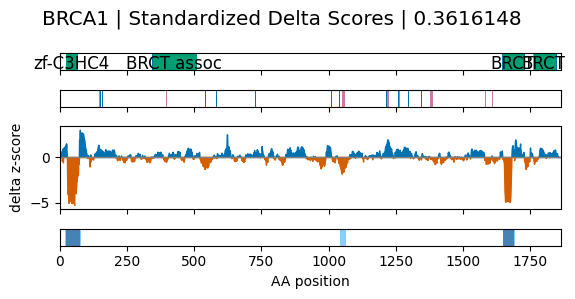

In [12]:
domain_coordinates = []
low_complexity_coordinates = []
sig_peaks_list = []
main4(rbps_list, p_threshold1=0.05, p_threshold2=0.001, savefig=True)
#main4(viz, p_threshold1=0.05, p_threshold2=0.001, savefig=True)
